<h1><center>Sample design - Stress/Strain anisotropy tester</center></h1>

In [1]:
from dolfin import *
# import pygmsh_mesh_functions
# from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For quality evaluation
from anisotropyv3_cdf import *

from scipy.io import loadmat
from scipy import interpolate

### Parameters for file to test

This is the **only section** you must edit !

For the constitutive model, you may choose between :
- '1-tanhplastic'
- '2-perfectplasticity'


In [2]:
# list available samples
from os import listdir
meshpath = './output_files/'
mesh_list = [x for x in listdir(meshpath) if x.endswith('.xdmf')]
mesh_list

['GWO119_Bezier_2fold.xdmf',
 'GWO120_Bezier_3fold.xdmf',
 'GWO121_freeHH_withholewall.xdmf',
 'GWO122_freeHH_withholewall.xdmf',
 'GWO126_Bezier_2fold.xdmf',
 'GWO127_Bezier_3fold.xdmf',
 'GWO128_freeHH_withholewall.xdmf']

823 elements in mesh


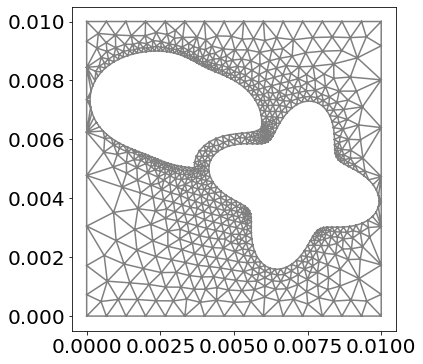

In [3]:
meshfile = mesh_list[6]                  # with .xdmf
meshpath = './output_files/'

sample_height=1     #IMPORTANT TO CHECK       #height of the sample in the mesh file (m)

mesh = Mesh()
with XDMFFile(meshpath+meshfile) as xdmf_infile:
    xdmf_infile.read(mesh)
n_elements = mesh.coordinates().shape[0]
print(str(n_elements)+" elements in mesh")

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
plot(mesh)
# ax.set_xlabel('$(\epsilon_x - \epsilon_y)/2$',fontsize=24)
# ax.set_ylabel('$\epsilon_{xy}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
ax.set_position([0.2, 0.15, 0.75, 0.75])
plt.savefig('example_mesh.png', dpi=96)

In [4]:
#Test loading profile
T_max = 40                                    #loading time length (s)
e_max = 0.005                                   #max upper boundary strain (no unit)
nb_steps = 15                                 #number of time steps during loading (default is 10)

In [5]:
# Mechanical Properties for sample design evaluation
# (default is given for steel https://www.matweb.com/search/datasheet.aspx?bassnum=MS0001&ckck=1 )

E_float = 200*1e9                                     #Young modulus (Pa)        default 200*1e9
nu_float = 0.25                                       #Poisson ratio (no unit)   default 0.25
sigma_y0_float = 350*1e6                              #Yield stress (Pa)         default 350*1e6

#MODEL PARAMETERS :
    #1-tanhplastic
sp=10
amp=0.1
    #2-perfectplasticity
#no parameters to define
    #3-

In [6]:
# To change the number of discrete segments to calculate anisotropy score :
# (default is 200)
n_seg=200
rel_thresh=1/3

## Plot stress states

### load data

In [7]:
Lx=0.01
Ly=0.01
lx=Lx
ly=Ly

In [8]:
#### Meshfile ####
meshpath = './output_files/'
datapath = './resultstester/'

In [9]:
# load data
mesh = meshio.read(datapath + meshfile +' - stess000001.vtu')
m_point = mesh.points
m_cell = mesh.cells[0].data
m_value = mesh.point_data

In [10]:
# load mesh
mesh = Mesh()
with XDMFFile(meshpath+meshfile) as xdmf_infile:
    xdmf_infile.read(mesh)
    
mesh_coord = mesh.coordinates()

In [11]:
# Compute polar coordinate in stress space
sigma_xx = m_value['$\\sigma$'][:,0]
sigma_yy = m_value['$\\sigma$'][:,4]
sigma_xy = m_value['$\\sigma$'][:,1]

sigma = np.array([[[sigma_xx[x],sigma_xy[x]],[sigma_xy[x],sigma_yy[x]]] for x in range(sigma_xx.shape[0])])

In [12]:
sigma.shape

(823, 2, 2)

In [13]:
n_element = sigma_xx.shape
n_frame = 1
sigma_test = sigma

# meshgrid
n_x = 50
n_y = 50
xc = np.arange(n_x+1)/n_x*lx
yc = np.arange(n_y+1)/n_y*ly
xx, yy = np.meshgrid(xc,yc)
N_xy = np.zeros_like(xx,dtype=bool)

# remove data from hole
x_grid = xx.reshape((n_x+1)*(n_y+1))
x_grid = yy.reshape((n_x+1)*(n_y+1))
for i in range(n_x+1):
    for j in range(n_y+1):
        contains = [cell.contains(Point(xc[i],yc[j])) for cell in cells(mesh)]
        N_xy[i,j] = any(contains)

list_matrix_index = [[0,0],[0,1],[1,0],[1,1]]

In [14]:
# interpolation
sigma_interp = np.zeros((n_x+1,n_y+1,2,2))
epsilon_interp = np.zeros((n_x+1,n_y+1,2,2))
for i, matrix_index in enumerate(list_matrix_index):
#     f = interpolate.interp2d(mesh_coord[:,0],mesh_coord[:,1],sigma_test[:,matrix_index[0],matrix_index[1]])
#     sigma_interp[:,:,matrix_index[0],matrix_index[1]] = f(xc, yc)
    sigma_interp[:,:,matrix_index[0],matrix_index[1]] = interpolate.griddata(mesh_coord,sigma_test[:,matrix_index[0],matrix_index[1]],(xx, yy),
                                                                             method='linear')

sigma_interp_inside = sigma_interp[N_xy.T,:,:]
n_element_inside = len(sigma_interp_inside)

sigma_normal = (sigma_interp_inside[:,0,0] - sigma_interp_inside[:,1,1])/2
sigma_shear = sigma_interp_inside[:,0,1]

sigma_all = np.vstack((sigma_normal,sigma_shear)).T.tolist()
sigma_i = np.vstack((sigma_normal,sigma_shear)).T.tolist()

In [15]:
len(sigma_test[:,matrix_index[0],matrix_index[1]])

823

### Stress states elastic

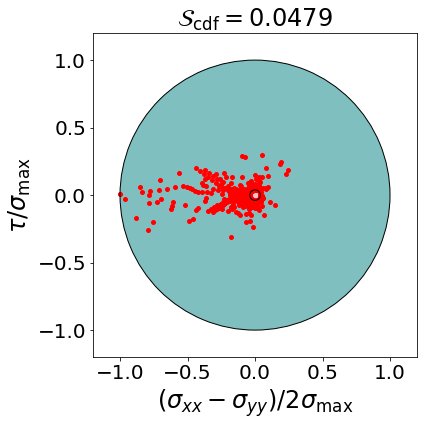

In [16]:
## Plot Demo
# score_gap = 0.04146607854805073 #0.036406236961257075, 0.03023210807953645, 0.04146607854805073
# score_cdf = 0.18286087936531595 #0.15227888517241092, 0.025594192318108958, 0.18286087936531595
score_cdfsq = 0.0478735214956731 #0.01890092907397273, 0.00041707335516127095, 0.0478735214956731

from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

quantile_sup = 1.0
quantile_inf = 0.5
coeff_sup = 1.0
coeff_inf = 1.0

np.random.seed(seed=2)
n_rays = len(sigma_normal)
# i_rays = np.random.choice(n_element,n_rays)
i_rays = np.arange(len(sigma_normal))
# colors = cm.viridis(np.linspace(0, 1, n_frame))

# for it in range(n_frame):
#     ax.plot(sigma_normal[:,it],sigma_shear[:,it],'.',color=colors[it],alpha=0.25,markersize=2)
r = np.sqrt(sigma_normal[i_rays]**2+sigma_shear[i_rays]**2)
max_r = np.max(r)

r_inf = np.quantile(r,quantile_inf)
r_sup = np.quantile(r,quantile_sup)

from matplotlib.patches import Circle, Wedge, Polygon
circle_rmax = Wedge((0,0),r_sup*coeff_sup/max_r,0,360,
                    width=(r_sup*coeff_sup-r_inf*coeff_inf)/max_r,fc='teal',alpha=0.5)
circle_rmax_edge = Wedge((0,0),r_sup*coeff_sup/max_r,0,360,
                    width=(r_sup*coeff_sup-r_inf*coeff_inf)/max_r,fill=False,alpha=1,edgecolor='k',zorder=4)

ax.add_patch(circle_rmax)
ax.add_patch(circle_rmax_edge)


sigma_lines = np.vstack((
                    np.vstack((sigma_normal[i_rays],
                           np.zeros_like(sigma_normal[i_rays]))).T.reshape(2*n_rays),
                    np.vstack((sigma_shear[i_rays],
                           np.zeros_like(sigma_shear[i_rays]))).T.reshape(2*n_rays)
                    ))/max_r

i_valid = i_rays[r >= r_inf*coeff_inf]

sigma_lines_valid = np.vstack((
                    np.vstack((sigma_normal[i_valid],
                           np.zeros_like(sigma_normal[i_valid]))).T.reshape(2*len(i_valid)),
                    np.vstack((sigma_shear[i_valid],
                           np.zeros_like(sigma_shear[i_valid,]))).T.reshape(2*len(i_valid))
                    ))/max_r

# ax.plot(sigma_normal[i_rays,i_frame]/max_r,sigma_shear[i_rays,i_frame]/max_r,'o',color='k',alpha=1,markersize=4)
ax.plot(sigma_normal[:]/max_r,sigma_shear[:]/max_r,'o',color='pink',alpha=1,markersize=4)
ax.plot(sigma_normal[i_valid]/max_r,sigma_shear[i_valid]/max_r,'o',color='r',alpha=1,markersize=4)
# ax.plot(sigma_lines[0],sigma_lines[1],'-',color='r',lw=0.5,alpha=0.4)
# ax.plot(sigma_lines_valid[0],sigma_lines_valid[1],'-',color='r',lw=1)

# print('rho = {:0.4f}'.format(corr[0,1]))
    
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel('$(\sigma_{xx} - \sigma_{yy})/2\sigma_{\mathrm{max}}$',fontsize=24)
ax.set_ylabel(r'$\tau/\sigma_{\mathrm{max}}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)

title_string = "$\mathcal{S}_{\mathrm{cdf}} = "+"{:.4f}".format(score_cdfsq)+"$"
ax.set_title(title_string, fontsize=24)

ax.set_position([0.2, 0.15, 0.75, 0.75])

pngname = datapath+meshfile+'_elast_grid_cdf_noline.png'
plt.savefig(pngname, dpi=96)